## prepare the data

download the data

```sh
# from root dir
kaggle competitions download -c dogs-vs-cats -p ./notebooks/data/cats_vs_dogs
cd notebooks/data/cats_vs_dogs
unzip -qq dogs-vs-cats.zip
unzip -qq train.zip
```

In [1]:
import os
import pathlib
import shutil

original_dir = pathlib.Path("./data/cats_vs_dogs/train")
new_base_dir = pathlib.Path("./data/cats_vs_dogs_small")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## build the model

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Metal device set to: Apple M1 Max


2023-01-29 15:30:20.722657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-29 15:30:20.722816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [4]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

## preprocess the data

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=(180, 180), batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=(180, 180), batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=(180, 180), batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### explore `Dataset` api

In [6]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

yield a single sample

In [7]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


`.batch()` the data

In [8]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


`.map(callable)` 

In [9]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


2023-01-29 15:30:21.138756: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


displaying the shapes of the data and labels yielded by the `Dataset`

In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## train the model

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras", save_best_only=True, monitor="val_loss"
    )
]
history = model.fit(
    train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/30


2023-01-29 15:30:21.529510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.4875

2023-01-29 15:30:24.317543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 4s 48ms/step - loss: 0.7232 - accuracy: 0.4875 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6955 - accuracy: 0.5090 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 3s 46ms/step - loss: 0.7419 - accuracy: 0.5925 - val_loss: 0.6562 - val_accuracy: 0.6300
Epoch 4/30
63/63 [==============================] - 3s 52ms/step - loss: 0.6463 - accuracy: 0.6395 - val_loss: 0.6176 - val_accuracy: 0.6900
Epoch 5/30
63/63 [==============================] - 3s 51ms/step - loss: 0.6194 - accuracy: 0.6745 - val_loss: 0.6364 - val_accuracy: 0.6340
Epoch 6/30
63/63 [==============================] - 3s 51ms/step - loss: 0.5685 - accuracy: 0.7120 - val_loss: 0.6037 - val_accuracy: 0.6770
Epoch 7/30
63/63 [==============================] - 3s 51ms/step - loss: 0.5369 - accuracy: 0.7260 - val_loss: 0.6379 - val_accuracy: 0.6280
Epoch 8/30
63/63 [======

### viz the metrics

In [12]:
import matplotlib.pyplot as plt


def viz_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

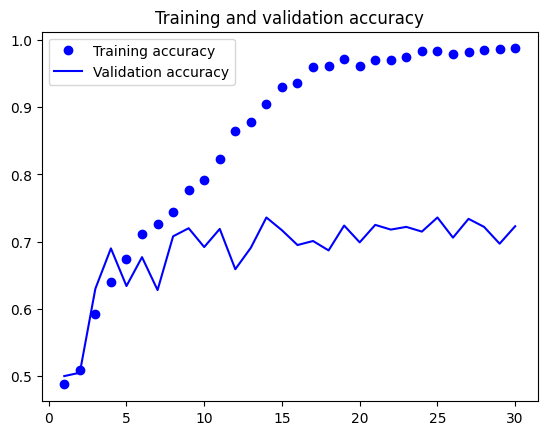

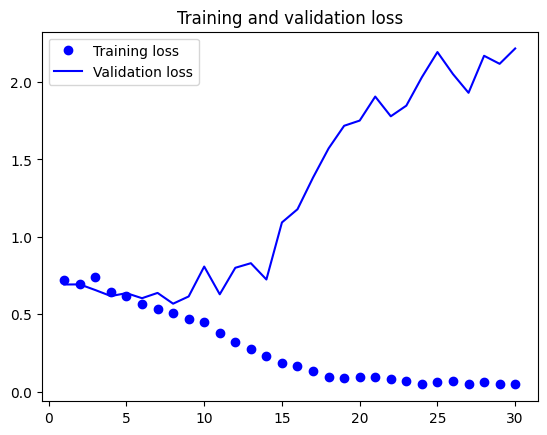

In [13]:
viz_history(history)

evaluate the model on the test set

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

 5/63 [=>............................] - ETA: 0s - loss: 0.5312 - accuracy: 0.7500

2023-01-29 15:32:02.381034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 15ms/step - loss: 0.5626 - accuracy: 0.7235
Test accuracy: 0.724


## data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2023-01-29 15:32:04.059286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:04.504496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:05.072131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:05.508626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:06.006682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:06.426352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:06.968021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:07.404320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:07.903788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:08.334180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:08.831033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:09.238083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:09.745183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:10.150852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:10.644178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:11.101262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:11.622471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-01-29 15:32:12.031658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


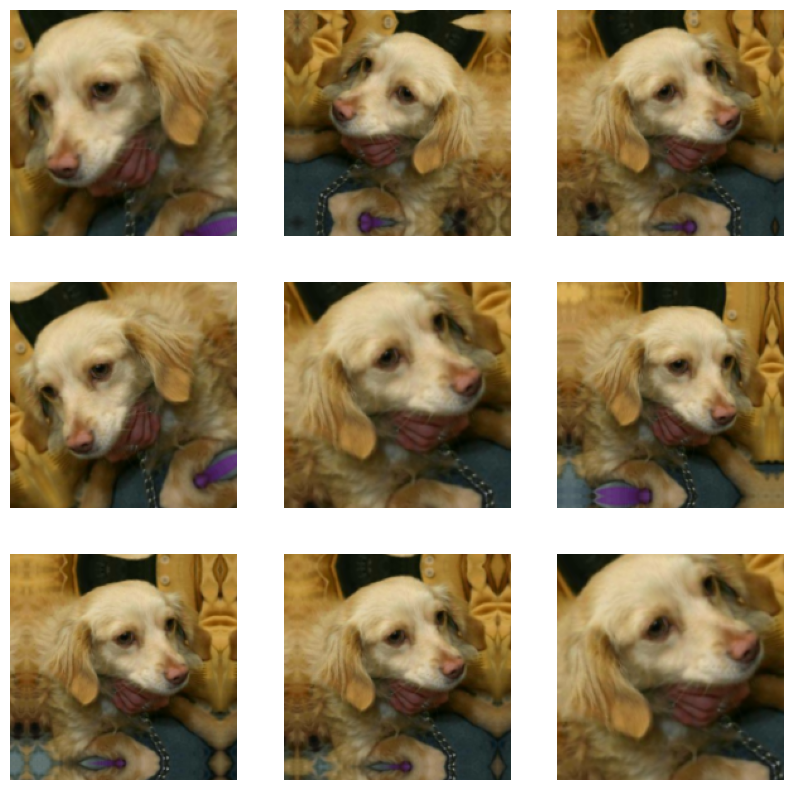

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### build the new model with data augmentation and dropout

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset, epochs=15, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/15


2023-01-29 15:32:14.185409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.5240

2023-01-29 15:32:36.422776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 24s 354ms/step - loss: 0.7465 - accuracy: 0.5240 - val_loss: 0.6951 - val_accuracy: 0.5260
Epoch 2/15
63/63 [==============================] - 23s 365ms/step - loss: 0.7006 - accuracy: 0.5250 - val_loss: 0.6850 - val_accuracy: 0.5250
Epoch 3/15
63/63 [==============================] - 23s 364ms/step - loss: 0.6789 - accuracy: 0.5880 - val_loss: 0.6878 - val_accuracy: 0.5780
Epoch 4/15
63/63 [==============================] - 22s 349ms/step - loss: 0.6672 - accuracy: 0.6315 - val_loss: 0.6440 - val_accuracy: 0.6430
Epoch 5/15
63/63 [==============================] - 22s 354ms/step - loss: 0.6526 - accuracy: 0.6415 - val_loss: 0.6836 - val_accuracy: 0.5650
Epoch 6/15
63/63 [==============================] - 21s 333ms/step - loss: 0.6353 - accuracy: 0.6540 - val_loss: 0.5957 - val_accuracy: 0.6800
Epoch 7/15
63/63 [==============================] - 21s 328ms/step - loss: 0.6080 - accuracy: 0.6815 - val_loss: 0.6121 - val_accuracy: 0.6710
Epoch 8/15

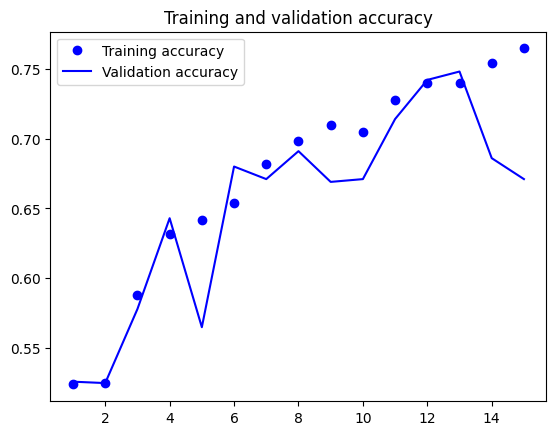

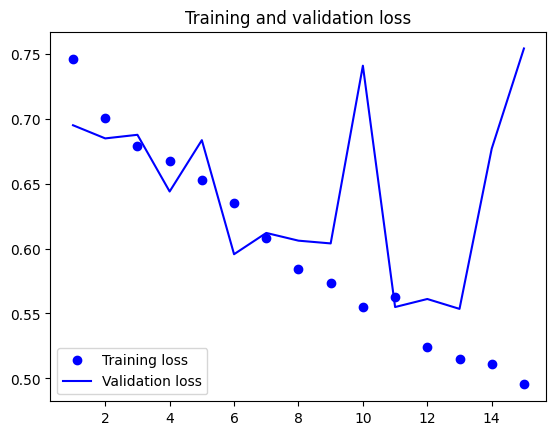

In [19]:
viz_history(history)

In [20]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

 5/63 [=>............................] - ETA: 0s - loss: 0.4764 - accuracy: 0.7875 

2023-01-29 15:37:49.137119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 15ms/step - loss: 0.5675 - accuracy: 0.7240
Test accuracy: 0.724


## Leveraging a pretrained model

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Fast feature extraction without data augmentation

In [23]:
import numpy as np


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 12ms/step


2023-01-29 15:37:50.611488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


2023-01-29 15:37:58.037064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


In [24]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier

In [25]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss"
    )
]
history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/20
 1/63 [..............................] - ETA: 18s - loss: 17.1735 - accuracy: 0.4062

2023-01-29 15:38:11.330438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 22.7127 - accuracy: 0.9145

2023-01-29 15:38:12.124212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 14ms/step - loss: 22.7127 - accuracy: 0.9145 - val_loss: 7.8210 - val_accuracy: 0.9500
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3.4785 - accuracy: 0.9760 - val_loss: 5.8002 - val_accuracy: 0.9620
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 2.6850 - accuracy: 0.9815 - val_loss: 2.5432 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.5062 - accuracy: 0.9860 - val_loss: 3.5256 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0863 - accuracy: 0.9910 - val_loss: 3.7760 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1.5621 - accuracy: 0.9895 - val_loss: 4.5883 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6794 - accuracy: 0.9930 - val_loss: 4.2014 - val_accuracy: 0.9780
Epoch 8/20
63/63 [=========

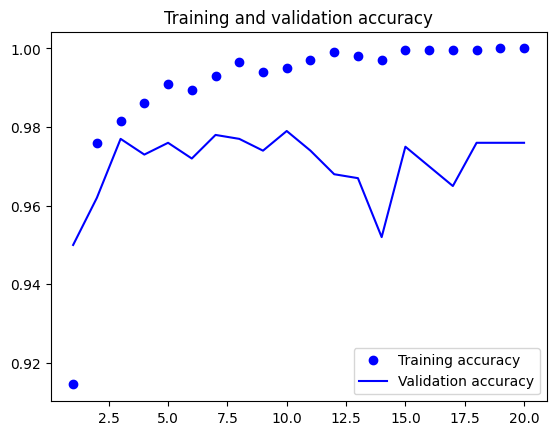

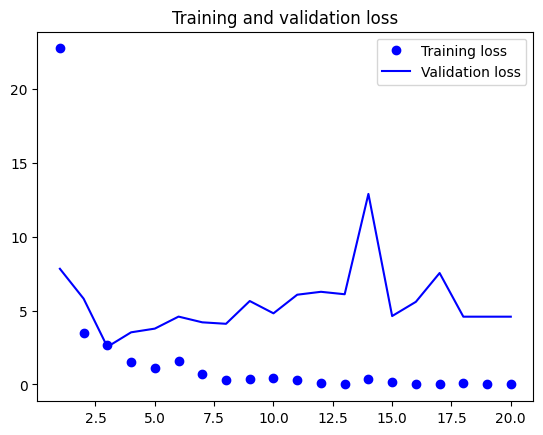

In [26]:
viz_history(history)

### Feature extraction together with data augmentation

In [27]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

In [28]:
conv_base.trainable = True
print(
    "This is the number of trainable weights " "before freezing the conv base:",
    len(conv_base.trainable_weights),
)

This is the number of trainable weights before freezing the conv base: 26


In [29]:
conv_base.trainable = False
print(
    "This is the number of trainable weights " "after freezing the conv base:",
    len(conv_base.trainable_weights),
)

This is the number of trainable weights after freezing the conv base: 0


In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset, epochs=15, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/15


2023-01-29 15:38:24.812568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 20.8828 - accuracy: 0.8960

2023-01-29 15:38:50.992039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 31s 460ms/step - loss: 20.8828 - accuracy: 0.8960 - val_loss: 3.1787 - val_accuracy: 0.9770
Epoch 2/15
63/63 [==============================] - 30s 473ms/step - loss: 5.7269 - accuracy: 0.9430 - val_loss: 3.1010 - val_accuracy: 0.9820
Epoch 3/15
63/63 [==============================] - 29s 464ms/step - loss: 4.2566 - accuracy: 0.9615 - val_loss: 4.2334 - val_accuracy: 0.9730
Epoch 4/15
63/63 [==============================] - 30s 469ms/step - loss: 3.5810 - accuracy: 0.9650 - val_loss: 2.6599 - val_accuracy: 0.9810
Epoch 5/15
63/63 [==============================] - 29s 464ms/step - loss: 3.6224 - accuracy: 0.9690 - val_loss: 3.1190 - val_accuracy: 0.9770
Epoch 6/15
63/63 [==============================] - 29s 465ms/step - loss: 2.2636 - accuracy: 0.9740 - val_loss: 4.2343 - val_accuracy: 0.9740
Epoch 7/15
63/63 [==============================] - 28s 450ms/step - loss: 2.8598 - accuracy: 0.9715 - val_loss: 3.8682 - val_accuracy: 0.9790
Epoch 8/1

In [32]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2023-01-29 15:45:46.150693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 8s 124ms/step - loss: 2.5337 - accuracy: 0.9760
Test accuracy: 0.976


## Fine-tuning a pretrained model

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [35]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss"
    )
]
history = model.fit(
    train_dataset, epochs=15, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/15


2023-01-29 15:45:55.015929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.9690

2023-01-29 15:46:23.820060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 33s 500ms/step - loss: 1.7823 - accuracy: 0.9690 - val_loss: 1.3415 - val_accuracy: 0.9790
Epoch 2/15
63/63 [==============================] - 32s 509ms/step - loss: 1.1350 - accuracy: 0.9760 - val_loss: 1.4240 - val_accuracy: 0.9810
Epoch 3/15
63/63 [==============================] - 32s 505ms/step - loss: 0.8362 - accuracy: 0.9775 - val_loss: 1.2829 - val_accuracy: 0.9800
Epoch 4/15
63/63 [==============================] - 30s 479ms/step - loss: 0.6489 - accuracy: 0.9810 - val_loss: 1.2609 - val_accuracy: 0.9820
Epoch 5/15
63/63 [==============================] - 30s 482ms/step - loss: 0.5461 - accuracy: 0.9810 - val_loss: 1.2836 - val_accuracy: 0.9770
Epoch 6/15
63/63 [==============================] - 30s 472ms/step - loss: 0.4726 - accuracy: 0.9875 - val_loss: 1.3133 - val_accuracy: 0.9760
Epoch 7/15
63/63 [==============================] - 31s 495ms/step - loss: 0.3909 - accuracy: 0.9835 - val_loss: 1.7513 - val_accuracy: 0.9790
Epoch 8/15

In [36]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2023-01-29 15:53:39.476794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 8s 125ms/step - loss: 1.0036 - accuracy: 0.9780
Test accuracy: 0.978
